In [1]:
#%% Import modules
import os
import numpy as np   
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import matplotlib.colors as mcolors 
import matplotlib.style as mstyle
import pandas as pandas
import cmocean
import datetime
import scipy as scipy
from scipy import stats,signal
import pandas
import xarray as xr              
from scipy.optimize import curve_fit


print("done importing modules")


done importing modules


## Define file locations

In [2]:
#%% Define file locations
## BLANCA
# WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_26_skipd01_ndg/"
# WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_26_skipd01_skipCoLES_ndg/"
# WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_28_skipd01_skipCoLES_ndg/"

## KESTREL
# WRF_DIRECTORY = "/scratch/mgomez/Hurricane/idealized/test/sst_30_skipd01_skipCoLES_ndg/"
# WRF_DIRECTORY = "/scratch/mgomez/Hurricane/idealized/test/sst_27real_skipd01_skipCoLES_ndg/"
# WRF_DIRECTORY = "/scratch/mgomez/STORM/idealSims/sst_32_skipd01_skipCoLES_ndg/"
WRF_DIRECTORY = "/projects/storm/mgomez/idealSims/sst_26_skipd01_skipCoLES_ndg/Results/"

# Choose which domain to evaluate
domain = 'd02'

# Whether or not to save figures
saveFig = 'False'

# Decide whether or not to save 1-min wind speed
saveCat = False

# Time series output for each restart
restarts = 'timeSeries_d02/' # timeSeries_d03


# Start time for simulations
startTime = np.datetime64('2000-01-01T00:00:00')
startTime_dom = np.datetime64('2000-01-06T10:00:00')

# Subsample data to reduce computational time and memory requirements
ss = 3


## Extract data

In [3]:
#%% Extract data for domain size
# Find auxHist files for current domain
entries = os.listdir(WRF_DIRECTORY)
ofInterest = []
for i in np.arange(len(entries)):
    if domain in entries[i]:
        if 'auxH' in entries[i]:
            ofInterest = np.append(ofInterest,i)
ofInterest = ofInterest.astype('int')
rndmFromInterest = np.random.choice(ofInterest)

# entries = ["auxHist24_d03_2000-01-06_12:25:30","auxHist24_d02_2000-01-06_12:35:30"]
# rndmFromInterest = 0

# entries = ["auxHist24_d02_2000-01-06_15:32:30"]
# rndmFromInterest = 0

print(entries[rndmFromInterest])


# Extract data from auxHist file
ds = xr.open_dataset(WRF_DIRECTORY+str(entries[rndmFromInterest]),decode_times=False)
u = ds['U']
u = np.array(u[0,:,:,:])
v = ds['V']
v = np.array(v[0,:,:,:])
w = ds['W']
w = np.array(w[0,:,:,:])
# De-stagger wind speed
u_des = 0.5*(u[:,:,0:np.shape(u)[2]-1]+u[:,:,1:np.shape(u)[2]])
u = 0.0
v_des = 0.5*(v[:,0:np.shape(v)[1]-1,:]+v[:,1:np.shape(v)[1],:])
v = 0.0
# horizontal wind speed
uv = np.sqrt(np.array(u_des)**2 + np.array(v_des)**2)
u_des = 0.0
v_des = 0.0
# Time
Time_3d = ds['Times']
a = str(np.array(Time_3d)[0])
ttime_3d = np.datetime64(a[2:12] + str(' ')+ a[13:-1])
# Domain dimensions
dx = ds.DX
n_x = dx*np.arange(0,np.shape(uv)[2])
n_y = dx*np.arange(0,np.shape(uv)[1])

# Save some memory
uv = uv[0:10,:,:]
w = w[0:10,:,:]

ds.close()


auxHist24_d02_2000-01-06_11:04:30


In [4]:
# Time series locations
# Station locations
locs = np.loadtxt(WRF_DIRECTORY +restarts+ '/tslist',skiprows=3,usecols=(2,3)) # [i,j]
name_locs = np.loadtxt(WRF_DIRECTORY +restarts+ '/tslist',skiprows=3,usecols=(1),dtype='U')

# Turbine specifications
D = 126 #240
z_hh = 90 #150
rated_ws = 11.4

# locs = locs[0:300,:]

print("Done extracting data from general variables")


Done extracting data from general variables


In [5]:
#%% Define use for each station
# Define number of "stations" for high-temporal resolution data 
if domain=='d05':
    which_stations = 'hi'
elif domain=='d04':
#     which_stations = 'lol'
    which_stations = 'd4'
elif domain=='d03':
    which_stations = 'd'
elif domain=='d02':
    which_stations = 'd3'

# Remove time series locations that are not going to be used in analysis
stations = []
for i in np.arange(len(name_locs)):
    if which_stations in name_locs[i]:
        stations = np.append(stations,i)
stations = stations.astype('int')
# stations = stations[:9]
# stations = stations[::9]
# stations = stations[18:63:2]
# stations = stations[85:100]
# stations = stations[18:11*9]
print(stations)
locs = locs[stations]
name_locs = name_locs[stations]
print(name_locs)

# Remove time series locations that are incorrect
if domain=='d05':
    stats = []
    for i in np.arange(len(name_locs)):
        if not locs[i,0] == locs[i,1]:
            stats = np.append(stats,i)       
    stats = stats.astype('int')
    print(stats)
    locs = locs[stats]
    name_locs = name_locs[stats]
    print(name_locs)

locs = locs.astype('int')

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [6]:
np.shape(locs)

(252, 2)

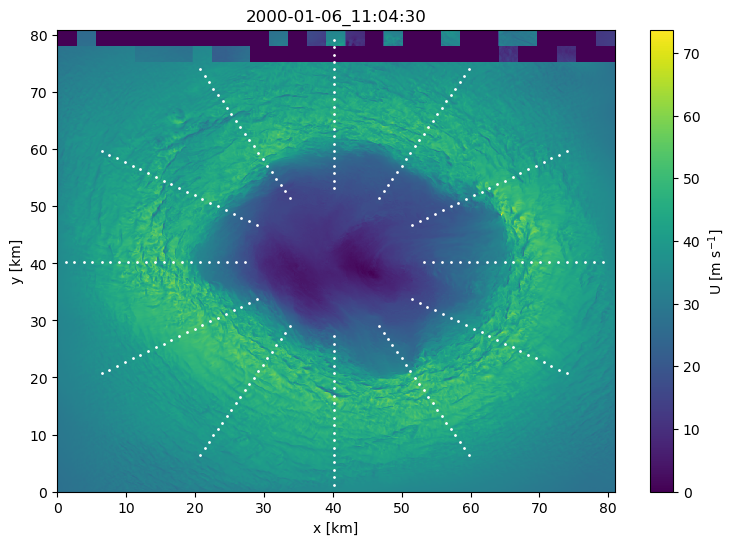

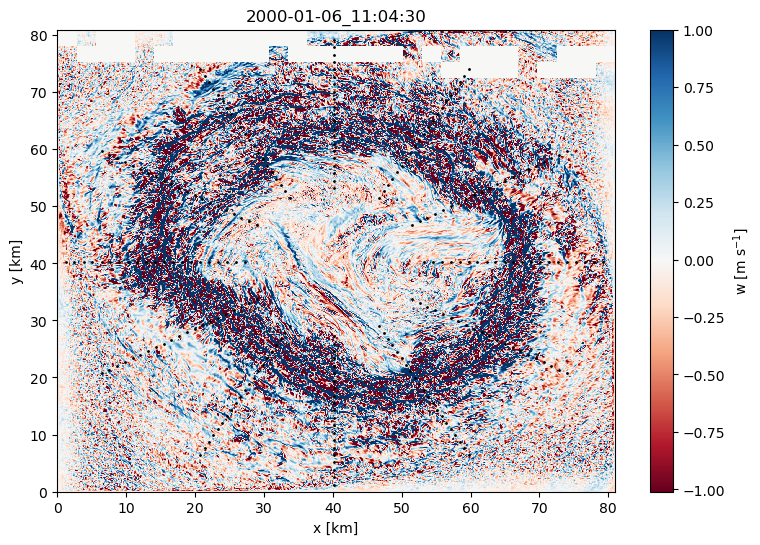

In [7]:
#%% Show relative locations of met tower in the domain
iz = 7

plt.figure(figsize=(9,6))
plt.title(str(Time_3d[0])[38:57])
im1 = plt.pcolormesh(n_x/1000,n_y/1000,uv[iz,:,:])
plt.scatter(n_x[locs[:,0]]/1000,n_y[locs[:,1]]/1000,s=1,color='white')
cbar = plt.colorbar(im1)
cbar.set_label("U [m s$^{-1}$]")
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.show()
plt.close()


# Vertical wind speed
plt.figure(figsize=(9,6))
plt.title(str(Time_3d[0])[38:57])
minn = -1.01 #np.min(w[iz,:,:])
maxx = 1.0 #np.max(w[iz,:,:])
newCmap = cmocean.tools.crop(plt.cm.RdBu, minn, maxx, 0)
im1 = plt.pcolormesh(n_x/1000,n_y/1000,w[iz,:,:],vmin=minn,vmax=maxx,cmap=newCmap)
plt.scatter(n_x[locs[:,0]]/1000,n_y[locs[:,1]]/1000,s=1,color='black')
cbar = plt.colorbar(im1)
cbar.set_label("w [m s$^{-1}$]")
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.show()
plt.close()


In [8]:
#%% Extract high-temporal resolution data
# Time arrays
temp = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[0]+'.'+domain+'.UU',skiprows=1)
temp = temp[0:-200,:]
init_temp = temp[:,0]
time = temp[::ss,0]*(3600/1) # seconds since start of simulation
time_sinceRst = time - time[0] # seconds since initialization
TIME = startTime + time.astype('timedelta64[s]')

# Height array
GHT = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[0]+'.'+domain+'.PH',skiprows=1)
hgt_agl_stg = GHT[::ss,1:] - GHT[0,1]
hgt_agl_stg = np.mean(hgt_agl_stg,axis=0)
hgt_agl = 0.5*(hgt_agl_stg[1:] + hgt_agl_stg[0:-1])
hgt_agl = np.append(hgt_agl,hgt_agl[-1] + (hgt_agl[-1] - hgt_agl[-2]))

# Initialize arrays [station,valForEachTimeStep,height]
U = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])
V = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])
# W = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])
# theta = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])

# Extract data for each station
for i_s in np.arange(0,len(locs)):
    # Load data
    tempU = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.UU',skiprows=1)
    tempV = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.VV',skiprows=1)
#     tempW = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.WW',skiprows=1)
#     tempT = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.TH',skiprows=1)
    # Save data
    U[i_s,:,:] = tempU[:np.shape(init_temp)[0]:ss,1:]
    V[i_s,:,:] = tempV[:np.shape(init_temp)[0]:ss,1:]
#     W[i_s,:,:] = tempW[:np.shape(init_temp)[0]:ss,1:]
#     theta[i_s,:,:] = tempT[:np.shape(init_temp)[0]:ss,1:]

    print('Done with %i out of %i' % (i_s,len(locs)-1))

# Release memory
tempU = 0.0
tempV = 0.0
# tempW = 0.0

print("Done extracting high-temporal resolution data")


Done with 0 out of 251
Done with 1 out of 251
Done with 2 out of 251
Done with 3 out of 251
Done with 4 out of 251
Done with 5 out of 251
Done with 6 out of 251
Done with 7 out of 251
Done with 8 out of 251
Done with 9 out of 251
Done with 10 out of 251
Done with 11 out of 251
Done with 12 out of 251
Done with 13 out of 251
Done with 14 out of 251
Done with 15 out of 251
Done with 16 out of 251
Done with 17 out of 251
Done with 18 out of 251
Done with 19 out of 251
Done with 20 out of 251
Done with 21 out of 251
Done with 22 out of 251
Done with 23 out of 251
Done with 24 out of 251
Done with 25 out of 251
Done with 26 out of 251
Done with 27 out of 251
Done with 28 out of 251
Done with 29 out of 251
Done with 30 out of 251
Done with 31 out of 251
Done with 32 out of 251
Done with 33 out of 251
Done with 34 out of 251
Done with 35 out of 251
Done with 36 out of 251
Done with 37 out of 251
Done with 38 out of 251
Done with 39 out of 251
Done with 40 out of 251
Done with 41 out of 251
Do

## Time step

In [9]:
#%% Mean time step in simulations
dt = np.mean(time[1:] - time[0:-1])

print(dt)


0.18055597588858796


## Clean data

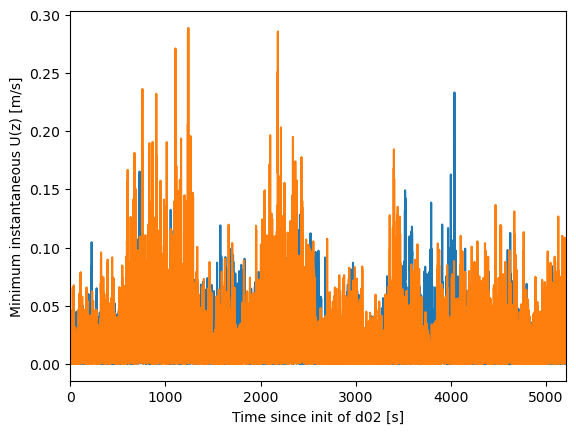

In [10]:
#%% Find virtual met-towers with wrong data

# Define wrong/corrupted conditions
u_vel = 0.0
v_vel = 0.0

# Find stations with wrong data
i_stat_wrong = np.zeros(np.shape(locs)[0])
for i_s in np.arange(np.shape(locs)[0]):
    # Compare wind fields at each station with wrong conditions
    wheres_u = np.where(U[i_s,:,:]==u_vel)[0]
    wheres_v = np.where(V[i_s,:,:]==v_vel)[0]
    if (len(wheres_u)>0):
        i_stat_wrong[i_s] = 1
        for iz in np.arange(len(hgt_agl)):
            tmp_where = np.where(U[i_s,:,iz]==u_vel)[0]
            if (len(tmp_where)>0):
                for ii_tt in tmp_where:
                    U[i_s,ii_tt,iz] = U[i_s,ii_tt-1,iz]
#                 U[i_s,tmp_where[:],iz] = np.nan
    if (len(wheres_v)>0):
        i_stat_wrong[i_s] = 1
        for iz in np.arange(len(hgt_agl)):
            tmp_where = np.where(V[i_s,:,iz]==v_vel)[0]
            if (len(tmp_where)>0):
                for ii_tt in tmp_where:
                    V[i_s,ii_tt,iz] = V[i_s,ii_tt-1,iz]
#                 V[i_s,tmp_where[:],iz] = np.nan
i_stat_wrong = i_stat_wrong.astype('int')

# Fiugre showing time series
plt.figure()
# plt.plot(time_sinceRst,np.nanmin(UV[:,:,:],axis=(0,2)))
plt.plot(time_sinceRst,np.nanmin(np.abs(U[:,:,:]),axis=(0,2)))
plt.plot(time_sinceRst,np.nanmin(np.abs(V[:,:,:]),axis=(0,2)))
plt.xlim(time_sinceRst[0],time_sinceRst[-1])
plt.xlabel('Time since init of ' + str(domain)+' [s]')
plt.ylabel('Minimum instantaneous U(z) [m/s]')
plt.show()
plt.close()

In [11]:
#%% Calculate horizontal wind speed and wind direction using time series output
# Calculate horizontal wind speed
UV = np.sqrt(U**2 + V**2)

# Calculate horizontal wind direction
wDir = np.zeros(np.shape(U))

for i_s in np.arange(np.shape(locs)[0]):
    for iz in np.arange(len(hgt_agl)):
        uu = np.zeros_like(U[i_s,:,iz]) + U[i_s,:,iz]
        vv = np.zeros_like(V[i_s,:,iz]) + V[i_s,:,iz]
#         vv[vv==0] = 0.1
#         wDir[i_s,:,iz] = np.arctan(uu/vv)*180/np.pi
        wDir[i_s,:,iz] = np.arctan2(vv,uu)*180/np.pi
        
# Wind direction in engineering coordinates (from [1,0] vector )
wDir[wDir<0] = (180 + wDir[wDir<0]) + 180

# Clear memory
U = 0.0
V = 0.0
uu = 0
vv = 0



## Hurricane center based on 3D fields

In [12]:
#%% Load data for temporal evolution of hurricane center for each height
# if domain == 'd03':
#     center_x = np.array([61324.50802739,53372.36928984]) #np.zeros(len(time_sinceRst)) + 52785.38902399
#     center_y = np.array([67166.13973252,56137.35728448]) #np.zeros(len(time_sinceRst)) + 54261.34061233
#     time_center_sinceRst = np.array([time_sinceRst[0], time_sinceRst[-1]]) #time_sinceRst + 0.0
    
#     center_x = np.array([np.mean(n_x),np.mean(n_x)])
#     center_y = np.array([np.mean(n_y),np.mean(n_y)])

# center_x = np.array([41667,42000]) #np.zeros(len(time_sinceRst)) + 52785.38902399
# center_y = np.array([41667,42000]) #np.zeros(len(time_sinceRst)) + 54261.34061233
# time_center_sinceRst = np.array([time_sinceRst[0], time_sinceRst[-1]]) #time_sinceRst + 0.0

# arr_x = np.loadtxt(WRF_DIRECTORY + '/center_x.txt',skiprows=1,delimiter=',')
# arr_y = np.loadtxt(WRF_DIRECTORY + '/center_y.txt',skiprows=1,delimiter=',')

arr_center = np.loadtxt(WRF_DIRECTORY+'center_inTime.txt',skiprows=1,delimiter=',',usecols=(0,1,2))
time_center = arr_center[:,0]
time_center_sinceRst = time_center - time_center[0]
center_x = arr_center[:,1]
center_y = arr_center[:,2]
    

Text(0, 0.5, 'r [km]')

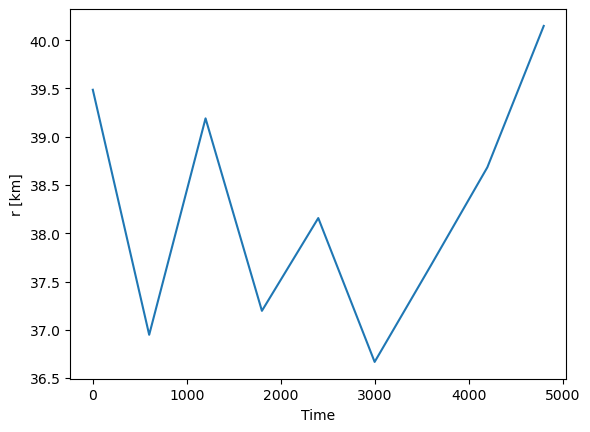

In [13]:
#%% Estimate temporal evolution of radial distance for each time series location at one height
radial_dist = np.zeros([len(time_center_sinceRst),np.shape(locs)[0]])
iz = 0

for it in np.arange(len(time_center_sinceRst)):
    if len(np.shape(center_x))==1:
        radial_dist[it,:] = ((n_x[locs[:,0]] - center_x[it])**2 + (n_y[locs[:,1]] - center_y[it])**2)**0.5
    else:
        radial_dist[it,:] = ((n_x[locs[:,0]] - center_x[it,iz])**2 + (n_y[locs[:,1]] - center_y[it,iz])**2)**0.5

# Time series of radial distance for a given met-tower at one height
plt.figure()
plt.plot(time_center_sinceRst,radial_dist[:,-1]/1000)
plt.xlabel('Time')
plt.ylabel('r [km]')

Text(0, 0.5, 'r [km]')

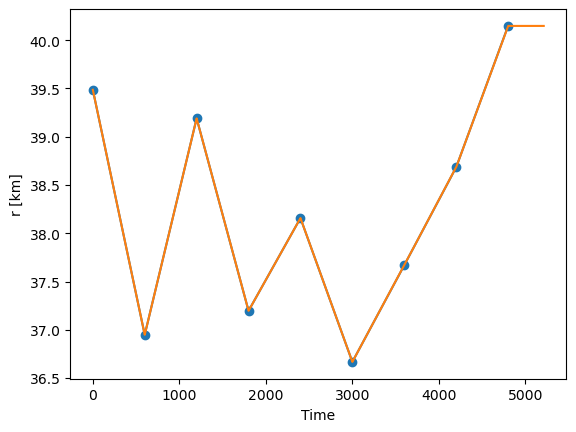

In [14]:
#%% Interpolate data in time to match time series output
# Interpolate radial distance from center of hurricane at z=10m
r_fromC = np.zeros([len(time_sinceRst),np.shape(locs)[0]]) # [time, station, radial distance]
for i_s in np.arange(np.shape(locs)[0]):
    r_fromC[:,i_s] = np.interp(time_sinceRst,time_center_sinceRst,radial_dist[:,i_s])
    
# Time series of radial distance for a given met-tower at one height
plt.figure()
plt.plot(time_center_sinceRst,radial_dist[:,-1]/1000,'-o')
plt.plot(time_sinceRst,r_fromC[:,-1]/1000)
plt.xlabel('Time')
plt.ylabel('r [km]')

## Define all functions

In [15]:
#%% Define moving average function
def moving_average(x, n,mode):
    mv_avg = np.zeros(np.shape(x))
    temp = np.convolve(x, np.ones(n), mode) / n #full valid same
    if mode=='valid':
        mv_avg[0:np.shape(x)[0]-n+1] = temp
        # Fill edges with data
        mv_avg[-n:] = np.sum(x[-n:])/n
    elif mode=='same':
        mv_avg = temp
        mv_avg[0:n] = np.sum(x[0:n])/n
        mv_avg[-n:] = np.sum(x[-n:])/n
    
    return mv_avg

#%% Define moving median function
from scipy.ndimage import median_filter
def moving_median(x, n):
    return median_filter(x[x != 0], n)


In [16]:
#%% Power law wind profile
def powLaw(z_z,alpha):
    u_o = u_curr;
    UUU = u_o*((z_z/z_hh)**alpha)
    return UUU

In [17]:
#%% Define functions that estimate change in wind direction

# Define function that estimates temporal change in wind direction for one height
def delta_wDir_oneZ(wDir1,wDir2):
    delta = np.abs(wDir1 - wDir2)
    
    if delta>180:
        delta = 360 - delta
        
    return delta



# Define function that estimates vertical change in wind direction for one time
def delta_wDir_twoZ(wDir1,wDir2,z1,z2,normalize):
    wDir_low = wDir1
    wDir_high = wDir2
    
    delta = 0
    
    if np.abs(wDir_high-wDir_low)<=0:#180:
        delta = wDir_high-wDir_low
    else:
        a = np.abs(wDir_high-wDir_low)
        b = np.abs(360-a)
        delta = np.min([a,b])
        
        if (wDir_high>=0) & (wDir_high<=90):
            if (wDir_low>=270) & (wDir_low<=360):
                delta = 1*delta
        elif (wDir_high>=270) & (wDir_high<=360):
            if (wDir_low>=0) & (wDir_low<=90):
                delta = -1*delta
    
    dz = z2-z1
    if dz>0:
        if normalize=='True':
            delta = delta/dz
        
    return delta


## Visualize spinup time

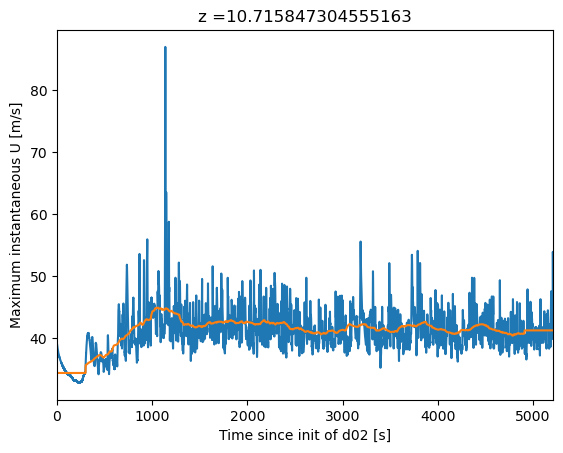

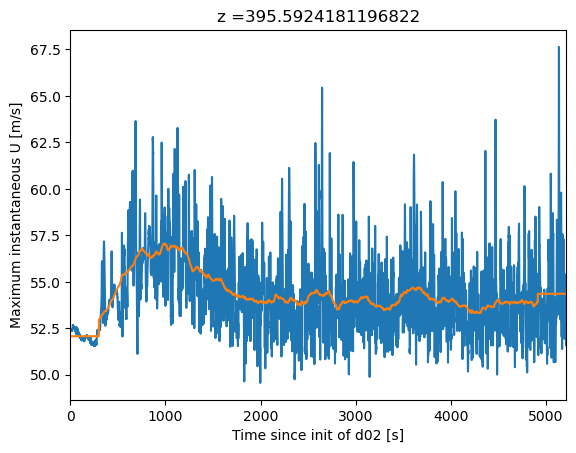

In [18]:
#%% Time series of maximum instantaneous wind speed at a given vertical level
# Define moving average window for spin-up
window_spinUp = 5*60 # [s]
n_window_spinUp = int(window_spinUp/dt)

col = plt.cm.viridis(np.linspace(0,1,len(locs)))

# Surface
iz = 0
plt.figure()
plt.title('z ='+str(hgt_agl[iz]))
plt.plot(time_sinceRst,np.nanmax(np.abs(UV[:,:,iz]),axis=0))
plt.plot(time_sinceRst,moving_average(np.nanmax(np.abs(UV[:,:,iz]),axis=0),n_window_spinUp,'same'))
plt.xlim(time_sinceRst[0],time_sinceRst[-1])
plt.xlabel('Time since init of ' + str(domain)+' [s]')
plt.ylabel('Maximum instantaneous U [m/s]')
plt.show()
plt.close()


# Boundary layer
iz = -1
plt.figure()
plt.title('z ='+str(hgt_agl[iz]))
plt.plot(time_sinceRst,np.nanmax(np.abs(UV[:,:,iz]),axis=0))
plt.plot(time_sinceRst,moving_average(np.nanmax(np.abs(UV[:,:,iz]),axis=0),n_window_spinUp,'same'))
plt.xlim(time_sinceRst[0],time_sinceRst[-1])
plt.xlabel('Time since init of ' + str(domain)+' [s]')
plt.ylabel('Maximum instantaneous U [m/s]')
plt.show()
plt.close()

# Remove data before spinup

In [19]:
#%% Time required for spinup
t_spin_0 = 30*60
if 'sst_26' in WRF_DIRECTORY:
    t_spin_0 = 33*60
elif 'sst_30' in WRF_DIRECTORY:
    t_spin_0 = 34*60
    
print("%f minutes (%f seconds) for spinup" % (t_spin_0/60, t_spin_0))

33.000000 minutes (1980.000000 seconds) for spinup


In [20]:
# Remove times before spinup

UV = UV[:,time_sinceRst>t_spin_0,:]
wDir = wDir[:,time_sinceRst>t_spin_0,:]
r_fromC = r_fromC[time_sinceRst>t_spin_0,:]
time_sinceRst = time_sinceRst[time_sinceRst>t_spin_0]


## Define heights within turbine rotor layer

In [21]:
#%% Turbine rotor layer
i_zzz_RL = np.where((hgt_agl>z_hh-0.55*D) & (hgt_agl<z_hh+0.6*D))[0]
i_zzz = np.where((hgt_agl>z_hh-1*D) & (hgt_agl<z_hh+0.6*D))[0]

print(hgt_agl[i_zzz])
print(hgt_agl[i_zzz_RL])

i_hh = i_zzz[0] + np.argmin(np.abs(hgt_agl[i_zzz] - z_hh)) + 1
print(hgt_agl[i_hh])

[ 10.7158473   32.67243342  55.70510139  79.86750199 105.2155287
 131.80778978 159.7056903 ]
[ 32.67243342  55.70510139  79.86750199 105.2155287  131.80778978
 159.7056903 ]
105.2155286984171


## Get moving averages and perturbation quantities from hurricane

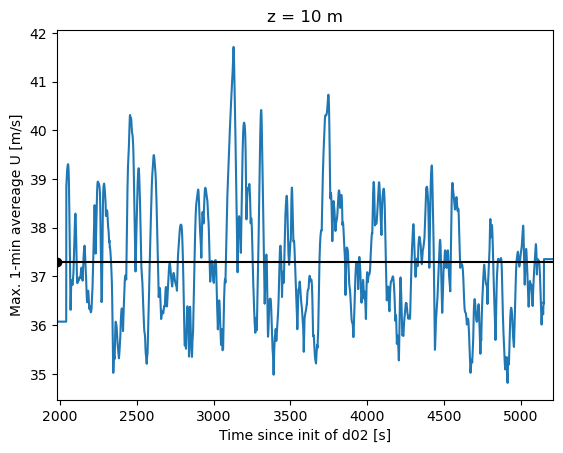

Category-1 Hurricane with 37.290000 m/s average max. 1-min sustained winds


In [22]:
#%% Hurricane intensity
window_1m = 1*60 # [s]
n_window_1m = int(window_1m/dt)

avgUV_1m = np.zeros(np.shape(UV))
avgUV_1m = avgUV_1m[:,:,0]

for i_s in np.arange(np.shape(UV)[0]):
    avgUV_1m[i_s,:] = moving_average(UV[i_s,:,0],n_window_1m,'same')
    
# Mean intensity
mean_intensity = np.mean(np.max(np.abs(avgUV_1m[:,time_sinceRst>t_spin_0]),axis=0))
hurr_intensity = np.max(np.abs(avgUV_1m),axis=0)
    
plt.figure()
plt.title('z = '+str(int(hgt_agl[0]))+" m")
# plt.plot(time_sinceRst,np.max(np.abs(UV[:,:,iz]),axis=0))
plt.plot(time_sinceRst,hurr_intensity)
plt.plot([t_spin_0,time_sinceRst[-1]+1000],[mean_intensity,mean_intensity],'-o',color='black')
plt.xlim(time_sinceRst[0],time_sinceRst[-1])
plt.xlabel('Time since init of ' + str(domain)+' [s]')
plt.ylabel('Max. 1-min avereage U [m/s]')
plt.show()
plt.close()

# print(mean_intensity)

## Intensity of storm
thres_Cat1 = 33
thres_Cat2 = 43
thres_Cat3 = 50
thres_Cat4 = 58
thres_Cat5 = 70


if mean_intensity < thres_Cat1:
    print("Tropical Storm with %f m/s average max. 1-min sustained winds" % np.round(mean_intensity,2))
elif (mean_intensity >= thres_Cat1) & (mean_intensity < thres_Cat2):
    print("Category-1 Hurricane with %f m/s average max. 1-min sustained winds" % np.round(mean_intensity,2))
elif (mean_intensity >= thres_Cat2) & (mean_intensity < thres_Cat3):
    print("Category-2 Hurricane with %f m/s average max. 1-min sustained winds" % np.round(mean_intensity,2))
elif (mean_intensity >= thres_Cat3) & (mean_intensity < thres_Cat4):
    print("Category-3 Hurricane with %f m/s average max. 1-min sustained winds" % np.round(mean_intensity,2))
elif (mean_intensity >= thres_Cat4) & (mean_intensity < thres_Cat5):
    print("Category-4 Hurricane with %f m/s average max. 1-min sustained winds" % np.round(mean_intensity,2))
elif mean_intensity>=thres_Cat5:
    print("Category-5 Hurricane with %f m/s average max. 1-min sustained winds" % np.round(mean_intensity,2))


if saveCat:
    import pickle
    fName = 'hurrCat.pkl'
    with open(WRF_DIRECTORY + fName, 'wb') as file:
        pickle.dump([time_sinceRst,hurr_intensity], file)
    stop
        

In [23]:
#%% Estimate 10-min horizontal wind speed statistics
window_10m = 10*60 # [s]
n_window_10m = int(window_10m/dt)

# Height of interest
zzz = z_hh
# i_zzz = np.argmin(np.abs(hgt_agl - zzz))

avgUV_10m = np.zeros(np.shape(UV))

for i_s in np.arange(np.shape(UV)[0]): # station
    for iz in i_zzz: #np.arange(np.shape(UV)[2]): # height
        avgUV_10m[i_s,:,iz] = moving_average(UV[i_s,:,iz],n_window_10m,'same')

# 10-min winds at hub height
avgUV_10m_hh = avgUV_10m[:,:,i_hh]

print('Done estimating %f second statistics' % window_10m)

Done estimating 600.000000 second statistics


In [24]:
#%% Estimate perturbation quantities for 10-min statistics
pertUV = UV[:,:,i_hh] - avgUV_10m_hh

# pertUV[np.isnan(pertUV)] = 0.0

# Detrend perturbations
pertUV = scipy.signal.detrend(pertUV,axis=1)

# Variance oh horizontal velocity
var_UV_hh = pertUV*pertUV

print('Done estimating perturbation quantities')

Done estimating perturbation quantities


In [25]:
#%% Estimate 3-sec horizontal wind speed statistics
window_3s = 3 # [s]
n_window_3s = int(window_3s/dt)

avgUV_3s_hh = np.zeros(np.shape(UV)[0:2])

# Height of interest
zzz = z_hh
# i_zzz = np.argmin(np.abs(hgt_agl - zzz))

avgUV_3s = np.zeros(np.shape(UV))

for i_s in np.arange(np.shape(UV)[0]): # station
    for iz in i_zzz: #np.arange(np.shape(UV)[2]): # height
        avgUV_3s[i_s,:,iz] = moving_average(UV[i_s,:,iz],n_window_3s,'same')

# 3-sec winds at hub height
avgUV_3s_hh = avgUV_3s[:,:,i_hh]

print('Done estimating %f second statistics' % window_3s)

Done estimating 3.000000 second statistics


## Hurricane size

In [26]:
# Define eyewall radius based on 3D fields
if 'sst_26' in WRF_DIRECTORY:
    r_eye = 13805
    r_eye = 25277.79764175 #23361
    label = '26 C'
elif 'sst_27' in WRF_DIRECTORY:
    r_eye = 18481
    r_eye = 19944.46011734 # 19138.9
    label = '27 C'
elif 'sst_28' in WRF_DIRECTORY:
    r_eye = 21300
    r_eye = 15833.3457756 # 15138
    label = '28 C'
elif 'sst_30' in WRF_DIRECTORY:
    r_eye = 20611.12730789 # 20333
    label = '30 C'
elif 'sst_32' in WRF_DIRECTORY:
    r_eye = 20388.90491104 # 21000
    label = '32 C'
# elif 'sst_34' in WRF_DIRECTORY:
#     r_eye = 33638.915
#     label = '34 C'

print('Eyewall radius at r = %f km' % (r_eye/1000))


Eyewall radius at r = 25.277798 km


## Select radial locations of interest for analysis

In [27]:
#%% Define radial locations of interest
# Radius of interest
r_r = np.arange(0.9,1.4,0.1)
# r_r = np.arange(0.8,1.3,0.1)
# r_r = np.arange(1.1,1.6,0.1)

# Indices for each timestep
i_rrr = np.zeros([len(time_sinceRst),np.shape(locs)[0]])  # [time,stat]

    
for i_s in np.arange(np.shape(locs)[0]):
    i_rrr[:,i_s] = (r_fromC[:,i_s]>r_r[0]*r_eye) & (r_fromC[:,i_s]<=r_r[-1]*r_eye)
i_rrr = i_rrr.astype('int')


# Get 3-sec and 10-min data for radii of interest (note that r is a function of time)
temp_arr_3s = np.zeros_like(avgUV_3s) + np.nan
temp_arr_10m = np.zeros_like(avgUV_10m) + np.nan
for i_s in np.arange(np.shape(locs)[0]):
    # temp_arr_3s[i_s,np.where(i_rrr[:,i_s])[0],:] = avgUV_3s[i_s,np.where(i_rrr[:,i_s])[0],:] + 0.0
    # temp_arr_10m[i_s,np.where(i_rrr[:,i_s])[0],:] = avgUV_10m[i_s,np.where(i_rrr[:,i_s])[0],:] + 0.0
    for i_t in np.arange(np.shape(avgUV_3s)[1]):
        if i_rrr[i_t,i_s]==1:
            temp_arr_3s[i_s,i_t,:] = avgUV_3s[i_s,i_t,:] + 0.0
            temp_arr_10m[i_s,i_t,:] = avgUV_10m[i_s,i_t,:] + 0.0



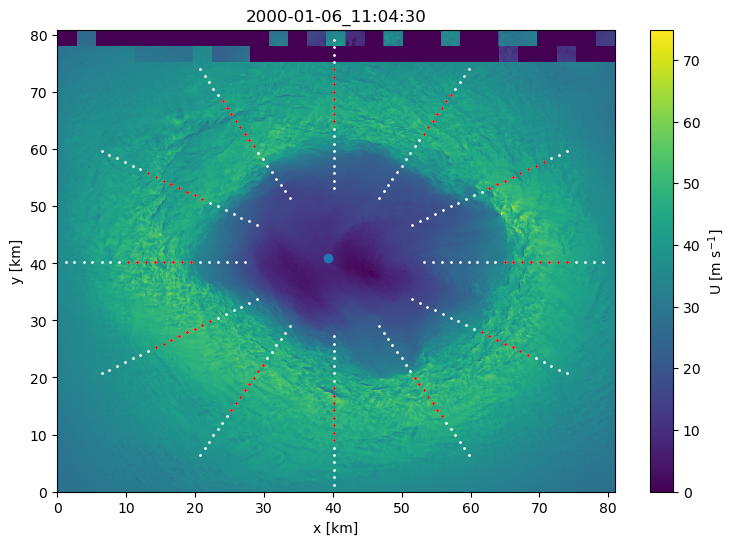

In [28]:
#%% Show met-tower locations within range

ittt = np.argmin(np.abs( time_sinceRst -  ((ttime_3d - startTime_dom)/np.timedelta64(1,'s'))))
ittt_cent = -1# np.argmin(np.abs( time_center_sinceRst - ((ttime_3d - startTime_dom)/np.timedelta64(1,'s'))))

iz = -1 #int(i_hh + 0)

plt.figure(figsize=(9,6))
plt.title(str(Time_3d[0])[38:57])
im1 = plt.pcolormesh(n_x/1000,n_y/1000,uv[iz,:,:])
plt.scatter(n_x[locs[:,0]]/1000,n_y[locs[:,1]]/1000,s=1,color='white')
if len(np.shape(center_x))>1:
    plt.scatter(center_x[ittt_cent,0]/1000,center_y[ittt_cent,0]/1000)
else:
    plt.scatter(center_x[ittt_cent]/1000,center_y[ittt_cent]/1000)
for i in np.arange(np.shape(locs)[0]):
    if (i_rrr[ittt,i]==1):
        plt.scatter(n_x[locs[i,0]]/1000,n_y[locs[i,1]]/1000,s=1,color='red')
cbar = plt.colorbar(im1)
cbar.set_label("U [m s$^{-1}$]")
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.show()
plt.close()


## Get hub-height wind speed and estimate alpha for radii of interest

In [29]:
#%% Get wind speed at hub height and fit alpha to wind profiles (at the same timestamps)

# Initialize arrays
UV_hh_10m_Rwithin = np.array([])
alpha_fit_10m_Rwithin = np.array([])
UV_hh_3s_Rwithin = np.array([])
alpha_fit_3s_Rwithin = np.array([])

# Get data
for i_s in np.arange(np.shape(locs)[0]):
    for it in np.arange(0,np.shape(avgUV_10m_hh)[1],n_window_3s):
        # 10-min winds
        u_curr = temp_arr_10m[i_s,it,i_hh]
        if np.sum(np.logical_not(np.isnan(temp_arr_10m[i_s,it,i_zzz_RL])))>0:
            # Calculate and save alpha
            popt, pcov = curve_fit(powLaw, hgt_agl[i_zzz_RL], temp_arr_10m[i_s,it,i_zzz_RL])
            alpha_fit_10m_Rwithin = np.append(alpha_fit_10m_Rwithin,[popt[0]])
            # Save hub-height winds
            UV_hh_10m_Rwithin = np.append(UV_hh_10m_Rwithin,[u_curr])
        # 3-sec winds
        u_curr = temp_arr_3s[i_s,it,i_hh]
        if np.sum(np.logical_not(np.isnan(temp_arr_3s[i_s,it,i_zzz_RL])))>0:
            # Calculate and save alpha
            popt, pcov = curve_fit(powLaw, hgt_agl[i_zzz_RL], temp_arr_3s[i_s,it,i_zzz_RL])
            alpha_fit_3s_Rwithin = np.append(alpha_fit_3s_Rwithin,[popt[0]])
            # Save hub-height winds
            UV_hh_3s_Rwithin = np.append(UV_hh_3s_Rwithin,[u_curr])
            

## Two-dimensional frequency distributions for U_hh vs alpha

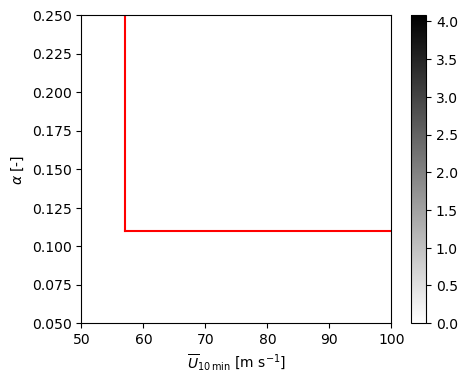

0.000000 percent of the data exceeds design standards for 10-min U_hh and alpha 


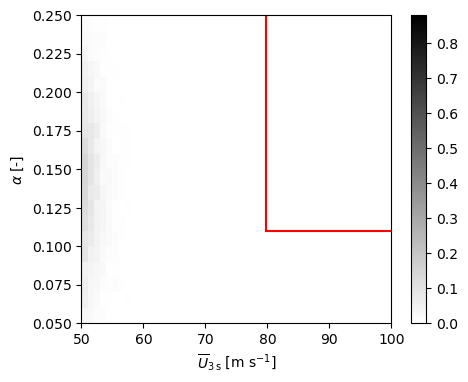

0.000000 percent of the data exceeds design standards for 3-sec U_hh and alpha 


In [30]:
#%% Make 2D probability distributions (avgHHWinds vs alpha)
## 10-min winds
# Get 2D distributions
uv_edges_10m = np.arange(10,100,1)
alpha_edges_10m = np.arange(-0.1,0.55,0.01)
Hist_2d_uv_alpha_10min, uv_edges_10m, alpha_edges_10m = np.histogram2d(UV_hh_10m_Rwithin, alpha_fit_10m_Rwithin, bins=(uv_edges_10m, alpha_edges_10m))
Hist_2d_uv_alpha_10min = 100*Hist_2d_uv_alpha_10min/np.sum(Hist_2d_uv_alpha_10min)
# Visualize results
plt.figure(figsize=(5,4))
plt.pcolormesh(uv_edges_10m,alpha_edges_10m,np.transpose(Hist_2d_uv_alpha_10min),vmin=0,vmax=np.nanmax(Hist_2d_uv_alpha_10min),cmap=plt.cm.binary)
plt.plot([57,100],[0.11,0.11],'-r')
plt.plot([57,57],[0.11,1],'-r')
plt.colorbar()
plt.xlim(50,100)
plt.ylim(0.05,0.25)
plt.xlabel(r"$\overline{U}_{\rm 10\, min}$ [m s$^{-1}$]")
plt.ylabel(r"$\alpha$ [-]")
plt.show()
plt.close()
# Percent of data that exceeds design criteria
tmp = Hist_2d_uv_alpha_10min[uv_edges_10m[1:]>57,:] + 0.0
tmp = tmp[:,alpha_edges_10m[1:]>0.11]
print("%f percent of the data exceeds design standards for 10-min U_hh and alpha " % np.sum(tmp))

## 3-sec winds
# Get 2D distributions
uv_edges_3s = np.arange(10,140,1)
alpha_edges_3s = alpha_edges_10m + 0.0
Hist_2d_uv_alpha_3sec, uv_edges_3s, alpha_edges_3s = np.histogram2d(UV_hh_3s_Rwithin, alpha_fit_3s_Rwithin, bins=(uv_edges_3s, alpha_edges_3s))
Hist_2d_uv_alpha_3sec = 100*Hist_2d_uv_alpha_3sec/np.sum(Hist_2d_uv_alpha_3sec)
# Visualize results
plt.figure(figsize=(5,4))
plt.pcolormesh(uv_edges_3s,alpha_edges_3s,np.transpose(Hist_2d_uv_alpha_3sec),vmin=0,vmax=np.nanmax(Hist_2d_uv_alpha_3sec),cmap=plt.cm.binary)
plt.plot([1.4*57,100],[0.11,0.11],'-r')
plt.plot([1.4*57,1.4*57],[0.11,1],'-r')
plt.colorbar()
plt.xlim(50,100)
plt.ylim(0.05,0.25)
plt.xlabel(r"$\overline{U}_{\rm 3\, s}$ [m s$^{-1}$]")
plt.ylabel(r"$\alpha$ [-]")
plt.show()
plt.close()
# Percent of data that exceeds design criteria
tmp = Hist_2d_uv_alpha_3sec[uv_edges_3s[1:]>1.4*57,:] + 0.0
tmp = tmp[:,alpha_edges_3s[1:]>0.11]
print("%f percent of the data exceeds design standards for 3-sec U_hh and alpha " % np.sum(tmp))


## Get yaw misalignment

In [31]:
#%% Estimate yaw misalignment
window_6s = 10 # [s]
n_window_6s = int(window_6s/dt)

# Height of interest
zzz = z_hh
i_zzz = np.argmin(np.abs(hgt_agl - zzz))

# Temporal change in wind direction over time window    
yaw_mis = np.zeros(np.shape(wDir)[0:2]) + np.nan
for i_s in np.arange(np.shape(locs)[0]):
    for i_t in np.arange(np.shape(wDir)[1]-n_window_6s):
        # Yaw-misalignment
        tempMax = 0
        mxx = np.max(wDir[i_s,i_t:i_t+n_window_6s,i_zzz])
        mnn = np.min(wDir[i_s,i_t:i_t+n_window_6s,i_zzz])
        tempMax = delta_wDir_oneZ(mxx,mnn)
        yaw_mis[i_s,i_t] = tempMax
    # print('Done with station ' + str(i_s) + ' of ' + str(np.shape(locs)[0]-1))

print('Done estimating yaw-misalignment for %f second statistics' % window_6s)

Done estimating yaw-misalignment for 10.000000 second statistics


## Get wind veer across rotor layer

In [32]:
#%% Get maximum change in wind direction over turbine rotor layer
# Decide whether or not to normalize veer
normalize = 'True'
print('normalize == ' + normalize)

# Time window for calculating wind veer
t_veer = 10 # [s]
n_window_veer = int(t_veer/dt) # [number of time steps]

# Heights covering turbine rotor layer
z_bott = z_hh - 0.5*D
z_top = z_hh + 0.5*D
iz_b = np.argmin(np.abs(hgt_agl - z_bott))
iz_t = np.argmin(np.abs(hgt_agl - z_top))

print('Turbine rotor layer is between %f and %f ' % (hgt_agl[iz_b],hgt_agl[iz_t]))

# Estimate veer over turbine rotor layer
veer_RL = np.zeros(np.shape(wDir)[0:2])
for i_s in np.arange(np.shape(locs)[0]):
    # Time-averaged wind direction at each height
    wDir_bott =  moving_median(wDir[i_s,:,iz_b],n_window_veer)
    wDir_top =  moving_median(wDir[i_s,:,iz_t],n_window_veer)
    for i_t in np.arange(len(time_sinceRst)-1):
        veer_RL[i_s,i_t] = delta_wDir_twoZ(wDir_bott[i_t],wDir_top[i_t],hgt_agl[iz_b],hgt_agl[iz_t],normalize)
    # print('Done with station ' + str(i_s) + ' of ' + str(np.shape(locs)[0]-1))



normalize == True
Turbine rotor layer is between 32.672433 and 159.705690 


## Radial increments for radial distributions

In [33]:
#%% Choose radial increments for radial distributions
dr_incr = 1000

# Radial locations for all met-towers
r_flat = r_fromC.flatten()
i_sort = np.argsort(r_flat)
r_sort = r_flat[i_sort]

# Radial increments
r_incr = np.arange(np.min(r_fromC),np.max(r_fromC),dr_incr)


## Save distributions for comparison

In [34]:
#%% Choose which distributinos to save
saveAlpha_distr = 'True'
save_oneDimProb = 'True';
saveYawMis_distr = 'True'
saveStd_distr = 'True'
saveVeer_distr = 'True'



 
Only using 3-s data 33.000000 min after restart
Mean 3-sec alpha is 0.145088
0.767948 fraction of cases display larger shear than design specifications
 
Only using 10-min data 33.000000 min after restart
Mean 10-min alpha is 0.144715
0.918627 fraction of cases display larger shear than design specifications


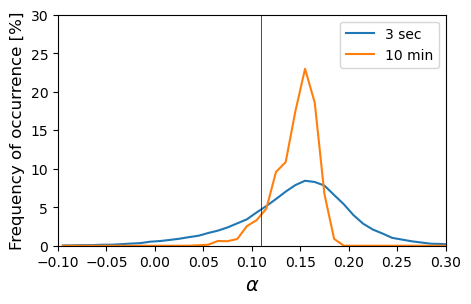

Wind shear is larger between r/R=[1,1.4] compared to r/R=[0.8,1.2]


In [35]:
#%% One-dimensional distributions for alpha

# Bins alpha
bins_alpha = alpha_edges_3s + 0.0

# Histograms
tttt = alpha_fit_3s_Rwithin.flatten() + 0.0
tttt = tttt[np.logical_not(np.isnan(tttt))]
print(" ")
print('Only using 3-s data %f min after restart' % (t_spin_0/60))
print("Mean 3-sec alpha is %f" % np.nanmean(tttt))
print("%f fraction of cases display larger shear than design specifications" % (np.sum(tttt>0.11)/np.sum(tttt>-100)))
# stop
hist_3s_alpha = np.histogram(tttt,bins=bins_alpha)
hist_3s_alpha = hist_3s_alpha[0]/np.nansum(hist_3s_alpha[0])

tttt = alpha_fit_10m_Rwithin.flatten() + 0.0
tttt = tttt[np.logical_not(np.isnan(tttt))]
print(" ")
print('Only using 10-min data %f min after restart' % (t_spin_0/60))
print("Mean 10-min alpha is %f" % np.nanmean(tttt))
print("%f fraction of cases display larger shear than design specifications" % (np.sum(tttt>0.11)/np.sum(tttt>-100)))
# stop
hist_10m_alpha = np.histogram(tttt,bins=bins_alpha)
hist_10m_alpha = hist_10m_alpha[0]/np.nansum(hist_10m_alpha[0])

bins_alpha = 0.5*(bins_alpha[1:] + bins_alpha[0:-1])

# Figure
plt.figure(figsize=(5,3))
plt.plot(bins_alpha,100*hist_3s_alpha,label='3 sec')
plt.plot(bins_alpha,100*hist_10m_alpha,label='10 min')
plt.plot([0.11,0.11],[0,100],'-k',linewidth=0.5)
plt.ylim(0,100*0.3)
plt.xlim(-0.1,0.3)
plt.xlabel(r"$\alpha$",fontsize=14)
plt.ylabel(r"Frequency of occurrence [%]",fontsize=12)
plt.legend()
plt.show()
plt.close()

#%% Save distributions of alpha
if saveAlpha_distr == 'True':
    fName = 'alpha_distr.txt'
    with open(WRF_DIRECTORY + fName, 'w') as f:
        for i in np.arange(len(bins_alpha)):
            strr = ''
            strr = str(bins_alpha[i])  + ',' + str(hist_3s_alpha[i]) + ',' + str(hist_10m_alpha[i])
            f.write(strr)
            f.write('\n')
            
print("Wind shear is larger between r/R=[1,1.4] compared to r/R=[0.8,1.2]")

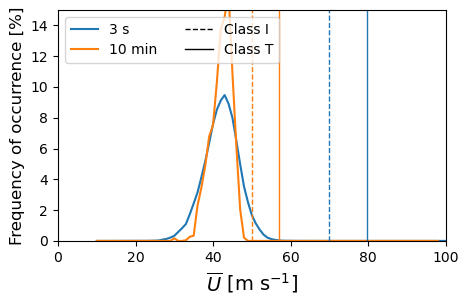

In [36]:
#%% One-dimensional distributions for 3-sec gust and 10-min wind speed
edges_gust = uv_edges_3s + 0.0
edges_mean = uv_edges_10m + 0.0

hist_gust_stats = np.histogram(UV_hh_3s_Rwithin,bins=edges_gust)[0]
hist_mean_stats = np.histogram(UV_hh_10m_Rwithin,bins=edges_mean)[0]

plt.figure(figsize=(5,3))
plt.plot(edges_gust[0:-1],100*hist_gust_stats/np.nansum(hist_gust_stats),label='3 s')
plt.plot(edges_mean[0:-1],100*hist_mean_stats/np.nansum(hist_mean_stats),label='10 min')
plt.plot([50,50],[0,100],linestyle='--',color='tab:orange',linewidth=1)
plt.plot([57,57],[0,100],linestyle='-',color='tab:orange',linewidth=1)
plt.plot([1.4*50,1.4*50],[0,100],linestyle='--',linewidth=1,color='tab:blue')
plt.plot([1.4*57,1.4*57],[0,100],linestyle='-',linewidth=1,color='tab:blue')
plt.plot([1.4*50,1.4*50],[0,-1],linestyle='--',linewidth=1,color='black',label='Class I')
plt.plot([1.4*57,1.4*57],[0,-1],linestyle='-',linewidth=1,color='black',label='Class T')
plt.ylim(0,100*0.15)
plt.xlim(0,100)
plt.xlabel(r"$\overline{U}$ [m s$^{-1}$]",fontsize=14)
plt.ylabel(r"Frequency of occurrence [%]",fontsize=12)
plt.legend(ncol=2,loc=2)
plt.show()
plt.close()

if save_oneDimProb=='True':
    import pickle
    fName_Prob_mean = 'prob_mean.pkl'
    fName_Prob_gust = 'prob_gust.pkl'
    fName_edges_gust = 'edges_gust2.pkl'
    fName_edges_mean = 'edges_mean2.pkl'
    with open(WRF_DIRECTORY + fName_Prob_mean, 'wb') as file:
        pickle.dump(hist_mean_stats, file)
    with open(WRF_DIRECTORY + fName_Prob_gust, 'wb') as file:
        pickle.dump(hist_gust_stats, file)
    with open(WRF_DIRECTORY + fName_edges_gust, 'wb') as file:
        pickle.dump(edges_gust, file)
    with open(WRF_DIRECTORY + fName_edges_mean, 'wb') as file:
        pickle.dump(edges_mean, file)


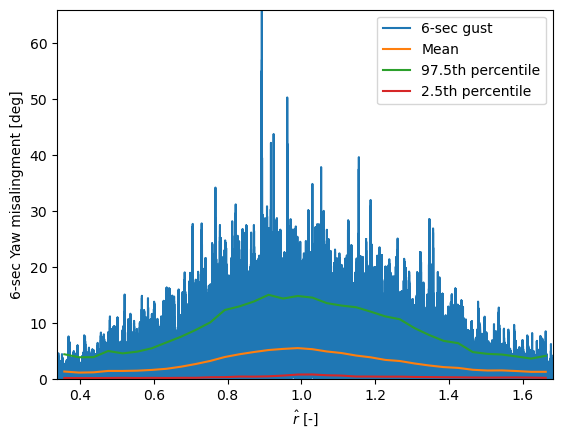

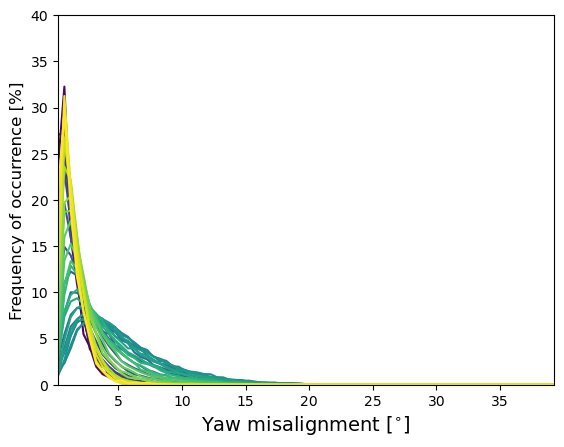

In [37]:
#%% One-dimensional distributions for 6-sec yaw-misalignment
## Prepare arrays
yaw_mis_flat  = np.transpose(yaw_mis).flatten()
# Sort arrays
yaw_mis_flat = yaw_mis_flat[i_sort]

## Get average 6-sec gust on dr_incr radial increments and i-th percentile
alpha_CI = 0.05
i_th = 1-(0.5*alpha_CI)
ii_th = 0.5*alpha_CI
mean_yawMis_6s_r = np.zeros(len(r_incr)-1)
ith_perc_yawMis_6s_r = np.zeros(len(r_incr)-1)
iith_perc_yawMis_6s_r = np.zeros(len(r_incr)-1)
for i_r in np.arange(len(r_incr)-1):
    temp_arr = yaw_mis_flat[(r_sort>r_incr[i_r]) & ((r_sort<=r_incr[i_r+1]))]
    temp_arr = temp_arr[np.logical_not(np.isnan(temp_arr))]
    mean_yawMis_6s_r[i_r] = np.nanmean(temp_arr)
    ith_perc_yawMis_6s_r[i_r] = np.percentile(temp_arr,i_th*100)
    iith_perc_yawMis_6s_r[i_r] = np.percentile(temp_arr,ii_th*100)
r_incr_ = 0.5*(r_incr[1:] + r_incr[0:-1])

plt.figure()
plt.plot(r_sort[::int(10/ss)+1]/r_eye,yaw_mis_flat[::int(10/ss)+1],label='6-sec gust')
plt.plot(r_incr_/r_eye,mean_yawMis_6s_r,label='Mean')
plt.plot(r_incr_/r_eye,ith_perc_yawMis_6s_r,label=str(np.round(i_th*100,2))+'th percentile')
plt.plot(r_incr_/r_eye,iith_perc_yawMis_6s_r,label=str(np.round(ii_th*100,2))+'th percentile')
plt.xlabel(r'$\hat{r}$ [-]')
plt.ylabel('6-sec Yaw misalingment [deg]')
plt.xlim(np.min(r_incr/r_eye),np.max(r_incr/r_eye))
plt.ylim(0,np.nanmax(yaw_mis_flat))
plt.legend()
plt.show()


# Distribution of max yaw misalignment at multiple radial locations
yaw_incr = np.arange(0,40,0.5)
distr_yawMis_r = np.zeros([len(r_incr)-1,len(yaw_incr)-1])
for ir in np.arange(len(r_incr)-1):
    temp_arr = yaw_mis_flat[(r_sort>r_incr[ir]) & ((r_sort<=r_incr[ir+1]))]
    temp_arr = temp_arr[np.logical_not(np.isnan(temp_arr))]
    distr_yawMis_r[ir,:] = np.histogram(temp_arr[temp_arr>0],bins=yaw_incr)[0]
bins_plot = 0.5*(yaw_incr[1:] + yaw_incr[0:-1])
norm_distr_yawMis_r = np.zeros_like(distr_yawMis_r) + distr_yawMis_r
for ii in np.arange(len(distr_yawMis_r[:,0])):
    norm_distr_yawMis_r[ii,:] = norm_distr_yawMis_r[ii,:]/np.sum(norm_distr_yawMis_r[ii,:])
    
plt.figure()
cols = plt.cm.viridis(np.linspace(0,1,len(distr_yawMis_r[:,0])))
for rr in np.arange(len(distr_yawMis_r[:,0])):
    plt.plot(bins_plot,100*norm_distr_yawMis_r[rr,:]/np.nansum(norm_distr_yawMis_r[rr,:]),color=cols[rr])
plt.xlabel(r"Yaw misalignment [$^{\circ}$]",fontsize=14)
plt.ylabel(r"Frequency of occurrence [%]",fontsize=12)
plt.xlim(bins_plot[0],bins_plot[-1])
plt.ylim(0,40)
plt.show()
plt.close()

#%% Save yaw misalignment distributions
if saveYawMis_distr == 'True':
    fName = 'yawMis_distr.txt'
    with open(WRF_DIRECTORY + fName, 'w') as f:
        for i in np.arange(len(bins_plot)+1):
            strr = ''
            if i==0:
                for ir in np.arange(len(r_incr)-1):
                    rrr = 0.5*(r_incr[ir]+r_incr[ir+1])
                    if ir == 0:
                        strr = strr + str(rrr)
                    else:
                        strr = strr + ',' + str(rrr)
            else:
                strr = strr + str(bins_plot[i-1]) 
                for rr in np.arange(len(distr_yawMis_r[:,0])):
                    strr = strr + ',' + str(norm_distr_yawMis_r[rr,i-1]) # yawMis,pdf_r_i
            f.write(strr)
            f.write('\n')
            

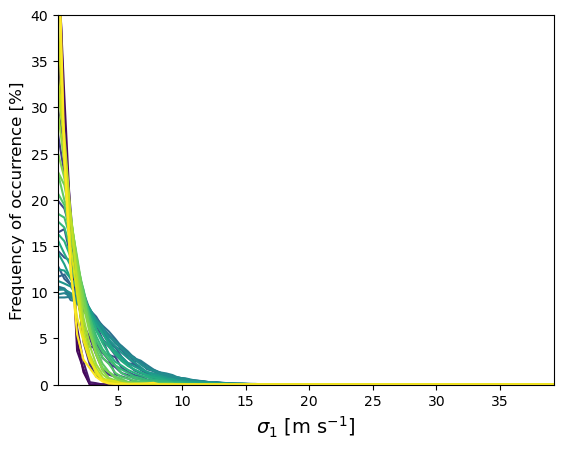

In [38]:
#%% Distribution of standard deviation at multiple radial locations
# Get radial distribution of 3-sec wind speed gust at hub height
var_UV_hh_flat  = np.transpose(var_UV_hh).flatten()
# Sort arrays
var_UV_hh_flat = var_UV_hh_flat[i_sort]
std_UV_hh_flat = var_UV_hh_flat**0.5


std_incr = np.arange(0,40,0.5)
distr_std_r = np.zeros([len(r_incr)-1,len(std_incr)-1])
for ir in np.arange(len(r_incr)-1):
    temp_arr = std_UV_hh_flat[(r_sort>r_incr[ir]) & ((r_sort<=r_incr[ir+1]))]
    temp_arr = temp_arr[np.logical_not(np.isnan(temp_arr))]
    distr_std_r[ir,:] = np.histogram(temp_arr[temp_arr>0],bins=std_incr)[0]
bins_plot = 0.5*(std_incr[1:] + std_incr[0:-1])

norm_distr_std_r = np.zeros_like(distr_std_r) + distr_std_r
for ii in np.arange(len(distr_std_r[:,0])):
    norm_distr_std_r[ii,:] = norm_distr_std_r[ii,:]/np.sum(norm_distr_std_r[ii,:])
    
plt.figure()
cols = plt.cm.viridis(np.linspace(0,1,len(distr_yawMis_r[:,0])))
for rr in np.arange(len(distr_yawMis_r[:,0])):
    plt.plot(bins_plot,100*norm_distr_std_r[rr,:]/np.nansum(norm_distr_std_r[rr,:]),color=cols[rr])
plt.xlabel(r"$\sigma_1$ [m s$^{-1}$]",fontsize=14)
plt.ylabel(r"Frequency of occurrence [%]",fontsize=12)
plt.xlim(bins_plot[0],bins_plot[-1])
plt.ylim(0,40)
plt.show()
plt.close()


#%% Save yaw misalignment distributions
if saveStd_distr == 'True':
    fName = 'std_distr.txt'
    with open(WRF_DIRECTORY + fName, 'w') as f:
        for i in np.arange(len(bins_plot)+1):
            strr = ''
            if i==0:
                for ir in np.arange(len(r_incr)-1):
                    rrr = 0.5*(r_incr[ir]+r_incr[ir+1])
                    if ir == 0:
                        strr = strr + str(rrr)
                    else:
                        strr = strr + ',' + str(rrr)
            else:
                strr = strr + str(bins_plot[i-1]) 
                for rr in np.arange(len(distr_std_r[:,0])):
                    strr = strr + ',' + str(norm_distr_std_r[rr,i-1]) # yawMis,pdf_r_i
            f.write(strr)
            f.write('\n')
            

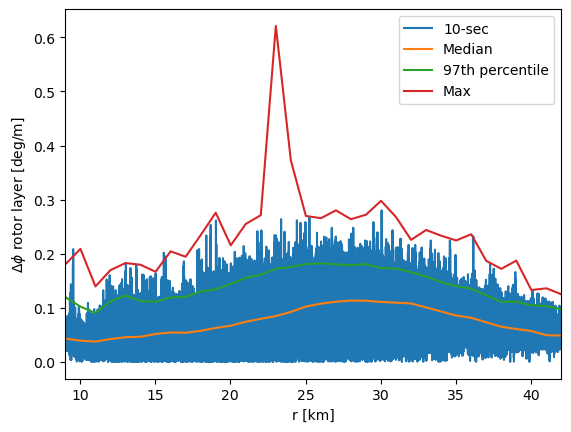

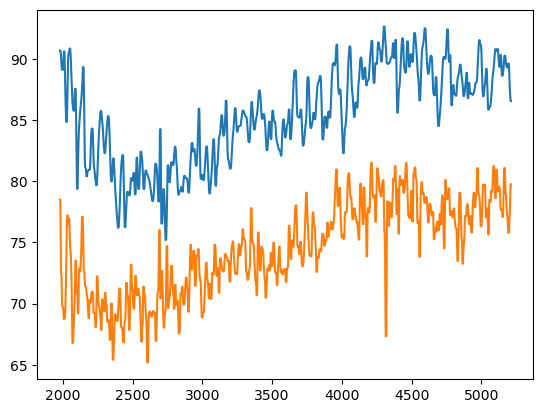

In [39]:
#%% Save wind veer radial distributions
## Get radial distribution of wind veer over turbine rotor layer
# Flatten arrays
r_flat = r_fromC.flatten()
veer_RL_flat  = np.transpose(veer_RL).flatten()
# Sort arrays
i_sort = np.argsort(r_flat)
r_sort = r_flat[i_sort]
veer_RL_flat = veer_RL_flat[i_sort]
# Average veer, ith percentile and maximum veer for each radial location
alpha_CI = 0.05
i_th = 1-(0.5*alpha_CI)
ii_th = 0.5*alpha_CI
mean_veer_RL_r = np.zeros(len(r_incr)-1)
max_veer_RL_r = np.zeros(len(r_incr)-1)
ith_perc_veer_RL_r = np.zeros(len(r_incr)-1)
iith_perc_veer_RL_r = np.zeros(len(r_incr)-1)
for i_r in np.arange(len(r_incr)-1):
    temp_arr = veer_RL_flat[(r_sort>r_incr[i_r]) & ((r_sort<=r_incr[i_r+1]))]
    temp_arr = np.abs(temp_arr)
    mean_veer_RL_r[i_r] = np.median(temp_arr)
    ith_perc_veer_RL_r[i_r] = np.percentile(temp_arr,i_th*100)
    iith_perc_veer_RL_r[i_r] = np.percentile(temp_arr,ii_th*100)
    max_veer_RL_r[i_r] = np.max(temp_arr)
    
r_incr_ = 0.5*(r_incr[1:] + r_incr[0:-1])

plt.figure()
plt.plot(r_sort[::50]/1000,np.abs(veer_RL_flat[::50]),label=str(t_veer)+'-sec')
plt.plot(r_incr_/1000,mean_veer_RL_r,label='Median')
plt.plot(r_incr_/1000,ith_perc_veer_RL_r,label=str(int(i_th*100))+'th percentile')
plt.plot(r_incr_/1000,max_veer_RL_r,label='Max')
plt.xlabel('r [km]')
if normalize=='True':
    plt.ylabel(r'$\Delta \phi$ rotor layer [deg/m]')
else:
    plt.ylabel(r'$\Delta \phi$ rotor layer [deg]')
plt.xlim(np.min(r_incr_/1000),np.max(r_incr_/1000))
plt.legend()
plt.show()    

# Time series of wid direction at two heights
plt.figure()
plt.plot(time_sinceRst,wDir_bott)
plt.plot(time_sinceRst,wDir_top)

if saveVeer_distr == 'True':
    fName = 'veer_Rdistr.txt'
    with open(WRF_DIRECTORY + fName, 'w') as f:
        for i in np.arange(len(r_incr)-1):
            strr = str(r_incr[i]) + ',' + str(mean_veer_RL_r[i]) + ',' + str(ith_perc_veer_RL_r[i])+ ',' + str(iith_perc_veer_RL_r[i]) + ',' + str(max_veer_RL_r[i])
                
            f.write(strr)
            f.write('\n')

## Radial distribution of wind speed and alpha

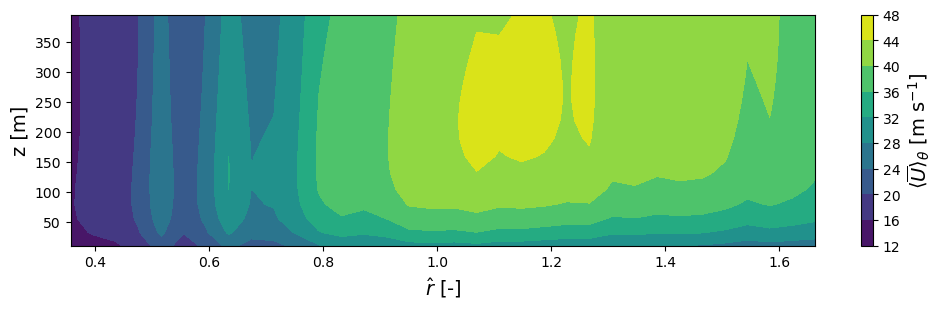

In [40]:
#%% Azimuthally averaged fields

r_t0 = radial_dist[0,:]

# Get time- and azimuthal-mean profiles at differnt radial locations
azim_mean_inst_U_prof = np.zeros([len(r_incr)-1,len(hgt_agl)])
for i_r in np.arange(len(r_incr)-1):
    i_r_within = (r_t0>r_incr[i_r]) & (r_t0<=r_incr[i_r+1])
    # Instantaneous
    azim_mean_inst_U_prof[i_r,:] = np.mean(UV[i_r_within,:,:],axis=(0,1))
r_incr_ = 0.5*(r_incr[1:] + r_incr[0:-1])



# Find radial distance for maximum in wind profile at each height
R_for_maxUV_atZ = np.zeros(len(hgt_agl))
for iz in np.arange(len(hgt_agl)):
    R_for_maxUV_atZ[iz] = r_incr_[np.argmax(azim_mean_inst_U_prof[:,iz])]

# Visualize fields
fig,axs = plt.subplots(1,1,figsize=(12,3))
im1 = axs.contourf(r_incr_/r_eye,hgt_agl,np.transpose(azim_mean_inst_U_prof))
# axs.plot(R_for_maxUV_atZ/r_eye,hgt_agl)
cbar1 = fig.colorbar(im1,ax=axs)
cbar1.set_label(r"$\langle \overline{U} \rangle_{\theta}$ [m s$^{-1}$]",fontsize=14)
axs.set_xlabel(r'$\hat{r}$ [-]',fontsize=14)
axs.set_ylabel(r'z [m]',fontsize=14)

plt.show()
plt.close()



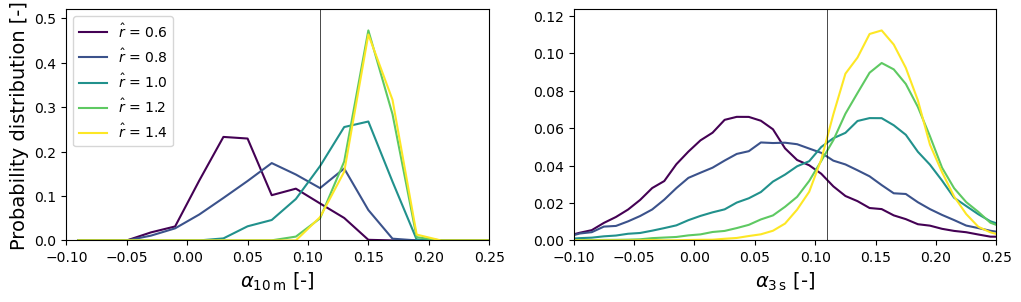

In [41]:
#%% Calculate alpha at each radial interval and get radial distribution of alpha

r_incr_alpha = np.arange(0.5,1.5+0.2,0.2)*r_eye
r_t0 = radial_dist[0,:]
bins_alpha_10m = np.arange(-0.1,0.55,0.02)
bins_alpha_3s = np.arange(-0.15,0.55,0.01)


# Get time- and azimuthal-mean profiles at differnt radial locations
azim_alpha_3s = np.zeros([len(r_incr_alpha)-1,len(bins_alpha_3s)-1]) # [r_incr, bins_alpha]
azim_alpha_10m = np.zeros([len(r_incr_alpha)-1,len(bins_alpha_10m)-1]) # [r_incr, bins_alpha]
for i_r in np.arange(len(r_incr_alpha)-1):
    i_r_within = (r_t0>r_incr_alpha[i_r]) & (r_t0<=r_incr_alpha[i_r+1])
    # Fit 3-s and 10-min profiles to power-law
    if np.sum(i_r_within)>0:
        wheres = np.where(i_r_within)[0]
        for i_stat in np.arange(len(wheres)):
            temp_alpha_3s = np.zeros(np.shape(avgUV_3s)[1]) + np.nan
            temp_alpha_10m = np.zeros(np.shape(avgUV_10m)[1]) + np.nan
            for it in np.arange(0,np.shape(avgUV_3s)[1],n_window_3s):
                # 3-second
                u_curr = avgUV_3s[wheres[i_stat],it,i_hh]
                popt, pcov = curve_fit(powLaw, hgt_agl[i_zzz_RL], avgUV_3s[wheres[i_stat],it,i_zzz_RL])
                temp_alpha_3s[it] = popt[0]
                # 10-min
                u_curr = avgUV_10m[wheres[i_stat],it,i_hh]
                popt, pcov = curve_fit(powLaw, hgt_agl[i_zzz_RL], avgUV_10m[wheres[i_stat],it,i_zzz_RL])
                temp_alpha_10m[it] = popt[0]
            # Remove NaNs
            temp_alpha_3s = temp_alpha_3s[np.logical_not(np.isnan(temp_alpha_3s))]
            temp_alpha_10m = temp_alpha_10m[np.logical_not(np.isnan(temp_alpha_10m))]
            # Save data
            temp_hist = np.histogram(temp_alpha_3s,bins=bins_alpha_3s)[0]
            azim_alpha_3s[i_r,:] = azim_alpha_3s[i_r,:] + temp_hist
            temp_hist = np.histogram(temp_alpha_10m,bins=bins_alpha_10m)[0]
            azim_alpha_10m[i_r,:] = azim_alpha_10m[i_r,:] + temp_hist

# Normalize distributions
for ir in np.arange(len(r_incr_alpha)-1):
    azim_alpha_10m[ir,:] = azim_alpha_10m[ir,:]/np.nansum(azim_alpha_10m[ir,:])
    azim_alpha_3s[ir,:] = azim_alpha_3s[ir,:]/np.nansum(azim_alpha_3s[ir,:])

# Center point of radial distances and alpha bins
bins_alpha_plot_3s = 0.5*(bins_alpha_3s[1:] + bins_alpha_3s[0:-1])
bins_alpha_plot_10m = 0.5*(bins_alpha_10m[1:] + bins_alpha_10m[0:-1])
r_incr_alpha_plot = 0.5*(r_incr_alpha[1:] + r_incr_alpha[0:-1])

# Figure showing alpha distribution at different radial locations
cols = plt.cm.viridis(np.linspace(0,1,np.shape(azim_alpha_3s)[0]))
plt.figure(figsize=(12,3))
ax0 = plt.subplot(1,2,1)
ax1 = plt.subplot(1,2,2)
for ir in np.arange(len(r_incr_alpha_plot)):
    ax0.plot(bins_alpha_plot_10m,azim_alpha_10m[ir,:],color=cols[ir],label=r'$\hat{r}$ = '+str(np.round(r_incr_alpha_plot[ir]/r_eye,2)))
    ax1.plot(bins_alpha_plot_3s,azim_alpha_3s[ir,:],color=cols[ir])
ax0.plot([0.11,0.11],[0,1],'-k',linewidth=0.5)
ax1.plot([0.11,0.11],[0,1],'-k',linewidth=0.5)
ax0.set_xlim(-0.1,0.25)
ax1.set_xlim(-0.1,0.25)
ax0.set_ylim(0,1.1*np.nanmax(azim_alpha_10m))
ax1.set_ylim(0,1.1*np.nanmax(azim_alpha_3s))
ax0.set_ylabel('Probability distribution [-]',fontsize=14)
ax0.set_xlabel(r'$\alpha_{10\,\mathrm{m}}$ [-]',fontsize=14)
ax1.set_xlabel(r'$\alpha_{3\,\mathrm{s}}$ [-]',fontsize=14)
ax0.legend()
plt.show()
plt.close()



<>:32: SyntaxWarning: invalid escape sequence '\o'
<>:33: SyntaxWarning: invalid escape sequence '\o'
<>:32: SyntaxWarning: invalid escape sequence '\o'
<>:33: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_3373173/3362463953.py:32: SyntaxWarning: invalid escape sequence '\o'
  ax2.set_xlabel("$\overline{U}_{3\, \mathrm{s}}$ [m s$^{-1}$]",fontsize=14)
/tmp/ipykernel_3373173/3362463953.py:33: SyntaxWarning: invalid escape sequence '\o'
  ax3.set_xlabel("$\overline{U}_{10\, \mathrm{min}}$ [m s$^{-1}$]",fontsize=14)


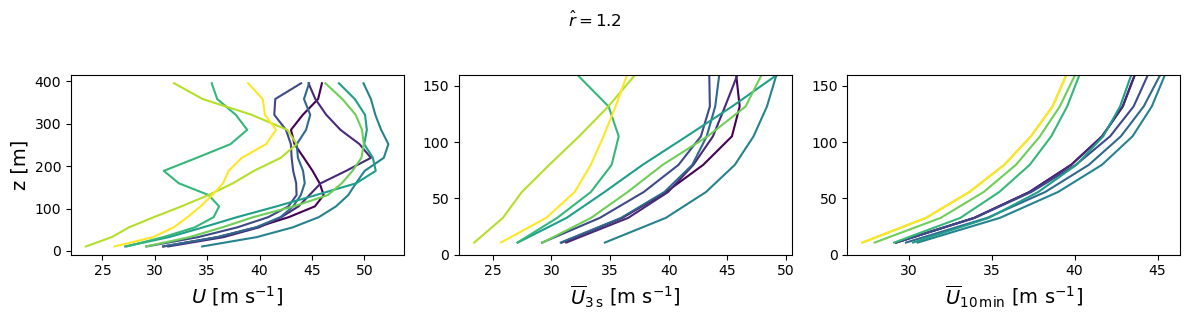

In [42]:
#%% Visualize temporal evolution of wind profile at one station

rad_dist = 1.2*r_eye

i_stst = np.argmin(np.abs(radial_dist[0,:]-rad_dist))

i_times = np.linspace(0,len(time_sinceRst)-1,10)
i_times = i_times.astype('int')
col = plt.cm.viridis(np.linspace(0,1,len(i_times)))

plt.figure(figsize=(12,3))
plt.suptitle(r"$\hat{r} = $" + str(np.round(rad_dist/r_eye,2)),y=1.05)
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)
for it in np.arange(len(i_times)):
    # Instantaneous
    ax1.plot(UV[i_stst,i_times[it],:],hgt_agl,color=col[it])
    # 3-second average
    tmp = avgUV_3s[i_stst,i_times[it],:] + 0.0
    tmp[tmp==0] = np.nan
    ax2.plot(tmp,hgt_agl,color=col[it])
    # 3-second average
    tmp = avgUV_10m[i_stst,i_times[it],:] + 0.0
    tmp[tmp==0] = np.nan
    ax3.plot(tmp,hgt_agl,color=col[it])
# ax1.set_ylim(0,np.max(hgt_agl[tmp>0]))
ax2.set_ylim(0,np.max(hgt_agl[tmp>0]))
ax3.set_ylim(0,np.max(hgt_agl[tmp>0]))
ax1.set_ylabel("z [m]",fontsize=14)
ax1.set_xlabel("$U$ [m s$^{-1}$]",fontsize=14)
ax2.set_xlabel("$\overline{U}_{3\, \mathrm{s}}$ [m s$^{-1}$]",fontsize=14)
ax3.set_xlabel("$\overline{U}_{10\, \mathrm{min}}$ [m s$^{-1}$]",fontsize=14)

plt.tight_layout()
plt.show()
plt.close()

In [43]:
hgt_agl[i_zzz_RL]

array([ 32.67243342,  55.70510139,  79.86750199, 105.2155287 ,
       131.80778978, 159.7056903 ])

## Wind speed profiles at multiple radial locations

In [44]:
#%% Decide whether or not to save profiles
saveProfs_r = 'True'


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


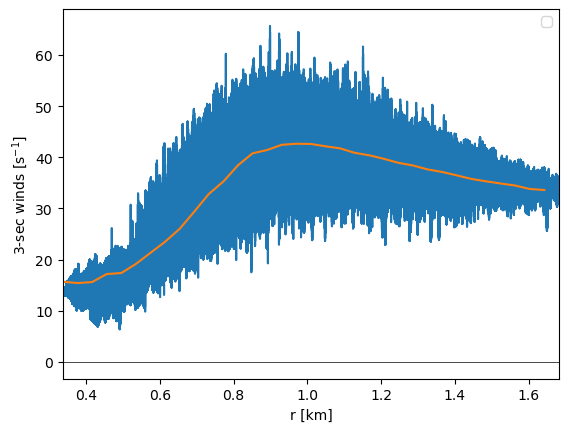

In [45]:
#%% Median 3-sec wind speed profiles at different radial locations
## Prepare arrays
almFlat_3s  = np.transpose(avgUV_3s,axes=(1,0,2)).reshape(np.product(np.shape(avgUV_3s)[0:2]),np.shape(avgUV_3s)[-1])
almFlat_10m  = np.transpose(avgUV_10m,axes=(1,0,2)).reshape(np.product(np.shape(avgUV_10m)[0:2]),np.shape(avgUV_10m)[-1])
# Sort arrays
almFlat_3s = almFlat_3s[i_sort,:]
almFlat_10m = almFlat_10m[i_sort,:]

## Get median for each incremetal radial location for 3-sec winds
i_median_r_3s = np.zeros(len(r_incr)-1)
for i_r in np.arange(len(r_incr)-1):
    temp_arr = almFlat_3s[(r_sort>r_incr[i_r]) & ((r_sort<=r_incr[i_r+1])),i_zzz]
    temp_arr = temp_arr[np.logical_not(np.isnan(temp_arr))]
    # Find median in array
    med = np.nanmedian(temp_arr)
    # Find value that is closest to median for this radial location
    i_temp = np.argmin(np.abs(temp_arr - med))
    val_temp = temp_arr[i_temp]
    # Find index of median in almFlat_3s array
    i_median_r_3s[i_r] = np.nanargmin(np.abs(val_temp - almFlat_3s[:,i_zzz]))
i_median_r_3s = i_median_r_3s.astype('int')   
# Check that I found the medioan
plt.figure()
plt.plot(r_sort[::int(10/ss)+1]/r_eye,almFlat_3s[::int(10/ss)+1,i_zzz])
plt.plot(r_incr[0:-1]/r_eye,almFlat_3s[i_median_r_3s,i_zzz])
plt.plot([0,100],[0,0],'-k',linewidth=0.5)
plt.xlabel('r [km]')
plt.ylabel('3-sec winds [s$^{-1}$]')
plt.xlim(np.min(r_incr/r_eye),np.max(r_incr/r_eye))
# plt.ylim(np.nanmin(sp_shear_flat),np.nanmax(sp_shear_flat))
plt.legend()
plt.show()

#%% Save wind speed profiles
if saveProfs_r == 'True':
    ## 3-sec winds
    fName = '3-sec_profiles.txt'
    with open(WRF_DIRECTORY + fName, 'w') as f:
        for i in np.arange(len(hgt_agl)+1):
            strr = ''
            # Show the radial location for each profile
            if i==0:
                for ir in np.arange(len(r_incr)-1):
                    rrr = 0.5*(r_incr[ir]+r_incr[ir+1])
                    if ir == 0:
                        strr = strr + str(rrr)
                    else:
                        strr = strr + ',' + str(rrr)
            else:
                # Save the velocity profile
                strr = strr + str(hgt_agl[i-1]) 
                for rr in np.arange(len(r_incr)-1):
                    strr = strr + ',' + str(almFlat_3s[i_median_r_3s[rr],i-1]) # z,U(r0),U(r1),... 
            f.write(strr)
            f.write('\n')


In [46]:
#%% Median 10-min awind speed profiles at different radial locations
# Release memory
almFlat_3s = 0.0

## Prepare arrays
almFlat_10m  = np.transpose(avgUV_10m,axes=(1,0,2)).reshape(np.product(np.shape(avgUV_10m)[0:2]),np.shape(avgUV_10m)[-1])
# Sort arrays
almFlat_10m = almFlat_10m[i_sort,:]

## Get median for each incremetal radial location for 10-min winds
i_median_r_10m = np.zeros(len(r_incr)-1)
for i_r in np.arange(len(r_incr)-1):
    temp_arr = almFlat_10m[(r_sort>r_incr[i_r]) & ((r_sort<=r_incr[i_r+1])),i_zzz]
    temp_arr = temp_arr[np.logical_not(np.isnan(temp_arr))]
    # Find median in array
    med = np.nanmedian(temp_arr)
    # Find value that is closest to median for this radial location
    i_temp = np.argmin(np.abs(temp_arr - med))
    val_temp = temp_arr[i_temp]
    # Find index of median in almFlat_3s array
    i_median_r_10m[i_r] = np.nanargmin(np.abs(val_temp - almFlat_10m[:,i_zzz]))
i_median_r_10m = i_median_r_10m.astype('int')   

#%% Save wind speed profiles
if saveProfs_r == 'True':
    ## 10-min winds
    fName = '10-min_profiles.txt'
    with open(WRF_DIRECTORY + fName, 'w') as f:
        for i in np.arange(len(hgt_agl)+1):
            strr = ''
            # Show the radial location for each profile
            if i==0:
                for ir in np.arange(len(r_incr)-1):
                    rrr = 0.5*(r_incr[ir]+r_incr[ir+1])
                    if ir == 0:
                        strr = strr + str(rrr)
                    else:
                        strr = strr + ',' + str(rrr)
            else:
                # Save the velocity profile
                strr = strr + str(hgt_agl[i-1]) 
                for rr in np.arange(len(r_incr)-1):
                    strr = strr + ',' + str(almFlat_10m[i_median_r_10m[rr],i-1]) # z,U(r0),U(r1),... 
            f.write(strr)
            f.write('\n')
            
            